## Dependencies

In [1]:
import sys
!{sys.executable} -m pip install -U imbalanced-learn
!{sys.executable} -m pip install -U python-slugify

## Dataset overview

In [2]:
import pandas as pd

df = pd.read_csv('company_bankrupcy.csv').dropna()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Imbalance Analysis


Is always helpful to know how imbalance the dataset is. Are there more positive samples than negatives ? How much ?

In [3]:
count = len(df)
stats = df[['Bankrupt?', ' After-tax net Interest Rate']]\
    .groupby(['Bankrupt?'])\
    .agg(['count'])\
    .reset_index(drop=True)\
    .rename(index={0: "OK", 1: "KO"})\
    .T.reset_index(drop=True, level=0).T

stats['pct'] = stats['count'] / count
stats

,count,pct
OK,6599,0.967737
KO,220,0.032263


It seems this dataset is highly imbalanced. Most of the samples are negative target samples, whereas only 3% of the samples are of type positive.

### Imbalanced: Resampling & Feature selection

We need to narrow down the number of features that are really relevant for classifying the samples between bankrupcy and bussiness as usual. The steps I'm going to do are:

- Correlation Matrix
- Scatter Matrix
- Lasso feature selection
- SBKBest feature selection

First I'm normalizing the **dataframe's columns names**

In [4]:
from slugify import slugify

columns = [slugify(name) for name in df.columns.values]
df.columns = columns
df.head()

,bankrupt,roa-c-before-interest-and-depreciation-before-interest,roa-a-before-interest-and-after-tax,roa-b-before-interest-and-depreciation-after-tax,operating-gross-margin,realized-sales-gross-margin,operating-profit-rate,pre-tax-net-interest-rate,after-tax-net-interest-rate,non-industry-income-and-expenditure-revenue,...,net-income-to-total-assets,total-assets-to-gnp-price,no-credit-interval,gross-profit-to-sales,net-income-to-stockholder-s-equity,liability-to-equity,degree-of-financial-leverage-dfl,interest-coverage-ratio-interest-expense-to-ebit,net-income-flag,equity-to-liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


Now I'm getting **target column** and the **rest of the columns** as features

In [5]:
target   = 'bankrupt'
features = [name for name in df.columns.values if name != 'bankrupt']

## RESAMPLING

In [6]:
from imblearn.over_sampling import SMOTE

X = df[features]
y = df[target]

# RESAMPLING
rnd = SMOTE()
X, y = rnd.fit_resample(X, y)

## SCALE

In [7]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

## FEATURE SELECTION

Creating initial target/features selection. I tried ALL but even a trivial matrix plot was taking forever. That's why I decided to do a top 10 feature selection directly.

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs            = SelectKBest(f_classif, k=10)
X_scaled      = fs.fit_transform(X_scaled, y)
cols          = fs.get_support(indices=True)
cols          = [name for name in df.columns[cols] if name != 'bankrupt']
cols

/opt/conda/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/conda/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['roa-c-before-interest-and-depreciation-before-interest',
 'roa-a-before-interest-and-after-tax',
 'tax-rate-a',
 'net-value-per-share-c',
 'operating-profit-per-share-yuan-y',
 'total-debt-total-net-worth',
 'debt-ratio',
 'operating-profit-paid-in-capital',
 'liability-assets-flag']

Now creating the scatter matrix to see feature distributions

## CROSS VALIDATION

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split

X = X_scaled

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def print_search_result(name, search_result):
    print(name)
    print("=" * len(name))
    print(search_result.best_params_, search_result.best_score_)
    print('---')
    
classifiers = [
    {
        'classifier': LogisticRegression(),
        'params': { 'C': [1, 5, 10, 20, 40] }
    },
    {
        'classifier': KNeighborsClassifier(),
        'params': { 'n_neighbors': [5, 10, 15] }
    },
    {
        'classifier': DecisionTreeClassifier(),
        'params': { 'max_depth': [3, 4, 5, 6] }
    }
]

for entry in classifiers:
    classifier = entry['classifier']
    classifier_name = type(classifier).__name__
    
    search_params   = entry['params']
    search_result   = GridSearchCV(classifier, param_grid=search_params, scoring='recall')\
        .fit(X_train, y_train)
    
    print_search_result(classifier_name, search_result)
    

LogisticRegression
{'C': 1} 0.8926910223286709
---
KNeighborsClassifier
{'n_neighbors': 5} 0.9531649031498819
---
DecisionTreeClassifier
{'max_depth': 6} 0.916512484124205
---


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

log = LogisticRegression(C=1).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
dtc = DecisionTreeClassifier(max_depth=6).fit(X_train, y_train)

lst = [log, knn, dtc]

## Decision functions

In [12]:
def get_y_predict(clsf, samples):
    dec_fun = getattr(clsf, 'decision_function', None)
    if dec_fun:
        return clsf.decision_function(samples)
    else:
        # only interested in positive score
        return clsf.predict_proba(samples)[0:, 1:]

## Precision/Recall curves

<Figure size 432x288 with 0 Axes>

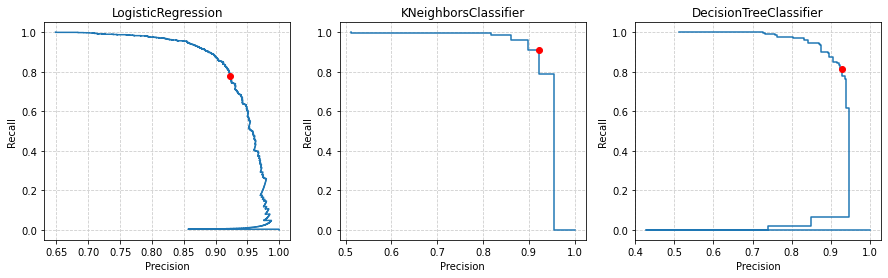

In [13]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# threshold I'm interested in
THRESHOLD = 0.75

plt.figure()
_, ax = plt.subplots(1, 3, figsize=(15, 4))
cols  = 0

# plotting precision-recall charts
for classifier in lst:
    y_predict = get_y_predict(classifier, X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    ax[cols].title.set_text(str(type(classifier).__name__))
    ax[cols].set(xlabel='Precision', ylabel='Recall')
    ax[cols].step(precision, recall)
    criteria = np.argmin(np.abs(thresholds - THRESHOLD))
    ax[cols].plot(precision[criteria], recall[criteria], 'o', c='r')
    ax[cols].grid(axis='both', linestyle='--', c='#cccccc')
    cols+=1

plt.show()

<Figure size 432x288 with 0 Axes>

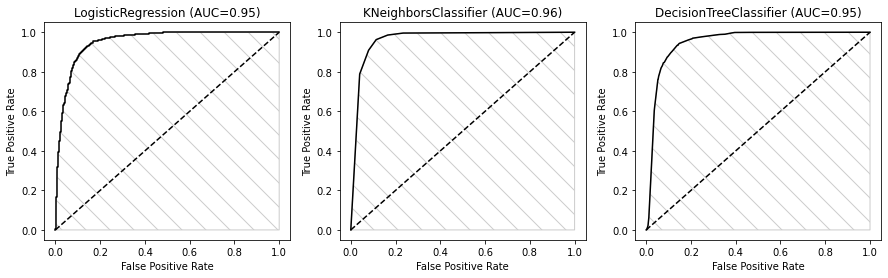

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure()
_, ax = plt.subplots(1, 3, figsize=(15, 4))
cols  = 0

for classifier in lst:
    classifier_name      = type(classifier).__name__
    # getting decision function prediction
    y_predict            = get_y_predict(classifier, X_test)

    # calculating FPR and TPR
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)

    # calculating the area under the curve
    roc_auc              = auc(fpr, tpr)
    
    ax[cols].title.set_text("{0} (AUC={1:.2f})".format(classifier_name, roc_auc))
    ax[cols].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax[cols].plot(fpr, tpr, c='k')
    ax[cols].plot([0, 1], [0, 1], c='k', linestyle='--')
    ax[cols].fill_between(fpr, tpr, hatch='\\', color='none', edgecolor='#cccccc')
    cols+=1
    
plt.show()

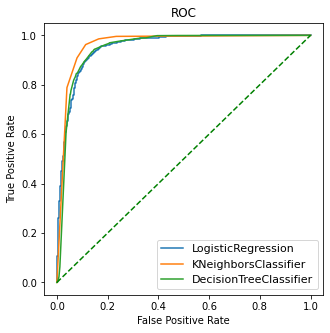

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(5, 5))

for classifier in lst:
    classifier_name      = type(classifier).__name__
    
    # calculating prediction using prediction functions
    y_predict            = get_y_predict(classifier, X_test)
    
    # calculating the roc curves
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    plt.plot(fpr, tpr, label=classifier_name)
    
plt.plot([0, 1], [0, 1], c='green', linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=11)
plt.show()